In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from bq_helper import BigQueryHelper
bq_assistant = BigQueryHelper("bigquery-public-data", "crypto_bitcoin")

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics

Using Kaggle's public dataset BigQuery integration.


In [3]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

Using Kaggle's public dataset BigQuery integration.


## Query

In [6]:
# return wallet balances based on transactions untill 2011-01-01

q = """
    DECLARE max_date DATE;
    DECLARE max_timestamp TIMESTAMP;
    SET max_date = '2011-01-01';
    SET max_timestamp = CAST(max_date AS TIMESTAMP);
    
    WITH sent AS (
        SELECT 
            ARRAY_TO_STRING(i.addresses, '') as address,
            count(DISTINCT t.block_number) as sent_trx_number,
            sum(i.value) as sent_total,
            min(i.value) as sent_min,
            avg(i.value) as sent_avg,
            max(i.value) as sent_max,
            min(t.input_count) as min_inputs,
            avg(t.input_count) as avg_inputs,
            max(t.input_count) as max_inputs,
            min(t.output_count) as min_outputs,
            avg(t.output_count) as avg_outputs,
            max(t.output_count) as max_outputs,
            min(t.block_timestamp) as first_trx_date_out,
            max(t.block_timestamp) as last_trx_date_out
        FROM `bigquery-public-data.crypto_bitcoin.transactions` as t, 
        UNNEST(inputs) as i
        WHERE t.block_timestamp_month < max_date
        GROUP BY 1
    ),   
    received AS (
        SELECT 
            ARRAY_TO_STRING(o.addresses, '') as address,
            count(DISTINCT t.block_number) as received_trx_number,
            sum(o.value) as received_total,
            min(o.value) as received_min,
            avg(o.value) as received_avg,
            max(o.value) as received_max,
            min(t.block_timestamp) as first_trx_date_in,
            max(t.block_timestamp) as last_trx_date_in,
            max(t.is_coinbase) as has_coinbase
        FROM `bigquery-public-data.crypto_bitcoin.transactions` as t, 
        UNNEST(outputs)as o
        WHERE t.block_timestamp_month < max_date
        GROUP BY 1
    )
    
    SELECT
        s.address,
        (r.received_total - s.sent_total) / 100000000 as balance,
        s.sent_trx_number as sent_trx_number,
        r.received_trx_number as received_trx_number,
        s.sent_total / 100000000 as sent_total,
        s.sent_min / 100000000 as sent_min,
        s.sent_avg / 100000000 as sent_avg,
        s.sent_max / 100000000 as sent_max,
        r.received_total / 100000000 as received_total,
        r.received_min / 100000000 as received_min,
        r.received_avg / 100000000 as received_avg,
        r.received_max / 100000000 as received_max,
        s.min_inputs as min_inputs,
        s.avg_inputs as avg_inputs,
        s.max_inputs as max_inputs,
        s.min_outputs as min_outputs,
        s.avg_outputs as avg_outputs,
        s.max_outputs as max_outputs,
        DATE_DIFF(max_timestamp, r.first_trx_date_in, DAY) as age_days,
        DATE_DIFF(s.last_trx_date_out, s.first_trx_date_out, DAY) as sent_range_days,
        DATE_DIFF(r.last_trx_date_in, r.first_trx_date_in, DAY) as received_range_days,
        DATE_DIFF(max_timestamp, s.last_trx_date_out, DAY) as sent_inactive_days,
        DATE_DIFF(max_timestamp, r.last_trx_date_in, DAY) as received_inactive_days,
        ( DATE_DIFF(s.last_trx_date_out, s.first_trx_date_out, DAY) / s.sent_trx_number) as send_freq,
        ( DATE_DIFF(r.last_trx_date_in, r.first_trx_date_in, DAY) / r.received_trx_number) as received_freq,
        CAST(r.has_coinbase AS INT64) as has_coinbase
    FROM sent as s 
    LEFT JOIN received as r
    ON s.address = r.address
    GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
"""

print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

0.08 GB


Извлечь адреса, у которых были транзакции за последние Х месяцев, подтянуть транзакции по этим адресам, чтобы корректно кластеризовать их.

# Fields description:
https://docs.google.com/document/d/1BV5XJm8bgOzH4B_01cg6y9hI71LpCEQ7Mo84Dcxe5dw


In [8]:
query_job = client.query(q)

# API request - run the query, and convert the results to a pandas DataFrame
trx11 = query_job.to_dataframe()

In [9]:
#################
# HERE WE START
#################
trx11

,address,balance,sent_trx_number,received_trx_number,sent_total,sent_min,sent_avg,sent_max,received_total,received_min,...,avg_outputs,max_outputs,age_days,sent_range_days,received_range_days,sent_inactive_days,received_inactive_days,send_freq,received_freq,has_coinbase
0,1EsHBdSHrHQ42UzoBYx6upKu9x25NFXyBP,0,4,4,171.98,23.99,42.995,50,171.98,23.99,...,1.75,2,601,218,46,379,555,54.5,11.5,1
1,16juSNx2hwNkGoEpDYu9s6kWjkmk8ufe13,0,1,1,0.01,0.01,0.01,0.01,0.01,0.01,...,1.00,1,597,0,0,597,597,0.0,0.0,0
2,1MjJkkBtL8TTQDQ8TNULe99xwWhz214YhS,0,1,1,1,1,1,1,1,1,...,1.00,1,597,0,0,597,597,0.0,0.0,0
3,1Patjwkpi829xZBrwooWM7whUHG4ZeWaab,0,1,1,50,50,50,50,50,50,...,2.00,2,601,0,0,599,601,0.0,0.0,1
4,1P2WeFtq3r7qLY7MsiVEiPbKrzR979F4HT,0,1,1,50,50,50,50,50,50,...,1.00,1,604,0,0,595,604,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111637,1PjVdymBEGLmuQ47pP1SZHbod8Z7eJGHU3,0,1,1,467.9,467.9,467.9,467.9,467.9,467.9,...,2.00,2,44,0,0,44,44,0.0,0.0,0
111638,1GP5qqFV4ZxLJWP1oXk618NjbWU5xCVen3,0,1,1,0.04,0.04,0.04,0.04,0.04,0.04,...,2.00,2,54,0,0,54,54,0.0,0.0,0
111639,1JuPBkcLsgc3yR8Z7CfG1R9RzcHJcQqXMJ,0,1,1,0.05,0.05,0.05,0.05,0.05,0.05,...,1.00,1,43,0,0,43,43,0.0,0.0,0
111640,12FAo3hwaqJzdBP8i1L8NpSSnLCcUhoQcF,0,1,1,0.06,0.06,0.06,0.06,0.06,0.06,...,2.00,2,40,0,0,40,40,0.0,0.0,0


In [10]:
#################
## DEFINE FEATURE LISTS
#################

features = ['balance', 'sent_trx_number', 'received_trx_number', 'sent_total', 'sent_min', 'sent_avg', 
            'sent_max', 'received_total', 'received_min', 'received_avg', 'received_max', 'min_inputs', 
            'avg_inputs', 'max_inputs', 'min_outputs', 'avg_outputs', 'max_outputs', 'age_days', 'sent_range_days', 
            'received_range_days', 'sent_inactive_days', 'received_inactive_days', 'send_freq', 'received_freq', 'has_coinbase']

In [11]:
#################
## DATASET ONLY WITH FEATURES
#################

df = trx11[features]
df.describe()

,sent_trx_number,received_trx_number,min_inputs,avg_inputs,max_inputs,min_outputs,avg_outputs,max_outputs,age_days,sent_range_days,received_range_days,sent_inactive_days,received_inactive_days,send_freq,received_freq,has_coinbase
count,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000,111642.000000
mean,1.089724,1.169623,42.740152,42.979137,43.276240,1.514045,1.520062,1.527418,149.557711,1.004407,1.085013,128.454309,148.457498,0.329806,0.325516,0.441053
std,1.861822,3.975921,128.900087,129.039407,129.596181,0.499805,0.496690,0.499250,124.544753,8.875025,9.467310,104.439771,124.991815,2.849243,2.826576,0.496515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,51.000000,0.000000,0.000000,46.000000,49.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,127.000000,0.000000,0.000000,105.000000,125.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,20.000000,20.000000,20.000000,2.000000,2.000000,2.000000,193.000000,0.000000,0.000000,170.000000,193.000000,0.000000,0.000000,1.000000
max,439.000000,636.000000,901.000000,901.000000,965.000000,2.000000,2.000000,2.000000,721.000000,433.000000,438.000000,718.000000,718.000000,183.500000,170.500000,1.000000


In [5]:
df

NameError: name 'df' is not defined

In [ ]:
df.hist()

## Scaling / Standardization

In [ ]:
# scaler = StandardScaler()
# scaler.fit(df)

# trans_df = pd.DataFrame(scaler.transform(df), columns = features)

array([[<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'sent_trx_number'}>,
        <AxesSubplot:title={'center':'received_trx_number'}>,
        <AxesSubplot:title={'center':'sent_total'}>,
        <AxesSubplot:title={'center':'sent_min'}>],
       [<AxesSubplot:title={'center':'sent_avg'}>,
        <AxesSubplot:title={'center':'sent_max'}>,
        <AxesSubplot:title={'center':'received_total'}>,
        <AxesSubplot:title={'center':'received_min'}>,
        <AxesSubplot:title={'center':'received_avg'}>],
       [<AxesSubplot:title={'center':'received_max'}>,
        <AxesSubplot:title={'center':'min_inputs'}>,
        <AxesSubplot:title={'center':'avg_inputs'}>,
        <AxesSubplot:title={'center':'max_inputs'}>,
        <AxesSubplot:title={'center':'min_outputs'}>],
       [<AxesSubplot:title={'center':'avg_outputs'}>,
        <AxesSubplot:title={'center':'max_outputs'}>,
        <AxesSubplot:title={'center':'age_days'}>,
        <AxesSubplot:title=

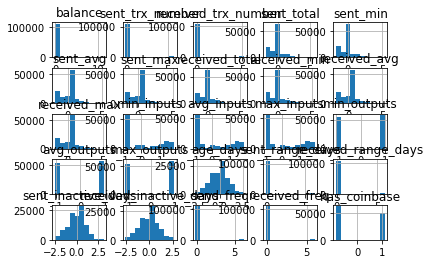

In [12]:
#################
## 1) SCALING / NORMALIZATION
#################

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)

trans_df = pd.DataFrame(pt.fit_transform(df), columns = features)

trans_df.hist()

## PCA with sklearn

In [13]:
#################
## 2) RUN PCA ON ALL 24 FEATURES, FIND OUT HOW MANY DIMENSIONS WE NEED
#################

pca = PCA(n_components=24) #choose the number of components = number of original dimensions

# use PCA on our data
pca.fit(trans_df)
pca.explained_variance_

array([8.36711215e+00, 5.47468557e+00, 5.33107418e+00, 2.23512896e+00,
       1.58180315e+00, 9.79997101e-01, 3.26076811e-01, 2.62321365e-01,
       1.78077268e-01, 1.02257079e-01, 6.49807811e-02, 5.52017988e-02,
       1.33338033e-02, 7.79877198e-03, 5.98373947e-03, 4.98390431e-03,
       3.92684773e-03, 1.70408456e-03, 1.38654628e-03, 1.03898708e-03,
       4.70316315e-04, 3.76873095e-04, 2.78790918e-04, 1.61366740e-04])

Text(0.5, 1.0, 'Explained variance with number of dimensions')

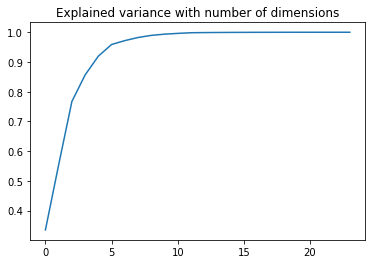

In [14]:
#################
## OPTIONAL - BUILD PLOT WITH EXPLAINED VARIANCE, MANUALLY PICK NUMBER OF COMPONENTS
#################

variances = np.cumsum(pca.explained_variance_ratio_)
plt.plot(variances)
plt.title('Explained variance with number of dimensions')

In [15]:
#################
## 3) REDUCTION OF FEATURES, KEEP AS MANY AS NEEDED
#################

pca = PCA(n_components=5)

reduced_df = pd.DataFrame(pca.fit_transform(trans_df))

In [ ]:
reduced_df.describe()

In [ ]:
reduced_df.hist()

## Calinski-Harabasz index
If the ground truth labels are not known, the Calinski-Harabasz index can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.
https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index

In [16]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [ ]:
# clusters = []
# noises = []
# indeces = []

# for e in range(1,20):
#     eps = e*0.1
#     db = DBSCAN(eps=eps, min_samples=100).fit(reduced_df)
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_

#     # Number of clusters in labels, ignoring noise if present.
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
#     index = metrics.calinski_harabasz_score(reduced_df, labels)
    
#     clusters.append(n_clusters_)
#     noises.append(n_noise_)
#     indeces.append(index)
    
# plt.figure(figsize=(15,10))
# plt.subplot(311)
# plt.plot(clusters)
# plt.title('Number of cluster')

# plt.subplot(312)
# plt.plot(noises)
# plt.title('Number of noisy observations')

# plt.subplot(313)
# plt.plot(indeces)
# plt.title('Calinski-Harabasz index')
# plt.show()

In [17]:
#################
## 4) CHOOSE CLUSTERING METHOD + HYPERPARAMETER TUNING + EVALUATION BETEWEEN METHODS/PARAMETERS
#################


db = DBSCAN(eps=1.6, min_samples=100).fit(reduced_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

metrics.calinski_harabasz_score(reduced_df, labels)

Estimated number of clusters: 3
Estimated number of noise points: 2643


24806.746302171145

In [ ]:
trx11['label'] = labels

In [ ]:
trx11.groupby('label')

In [ ]:
# plt.figure(figsize=(15, 10))
# plt.scatter(reduced_df[3], reduced_df[4], s=2, c=labels, cmap='Paired')

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>,
        <AxesSubplot:xlabel='4', ylabel='3'>],
       [<AxesSubplot:xlabel='0', ylabel='4'>,
        <AxesSubplot:xlabel='1

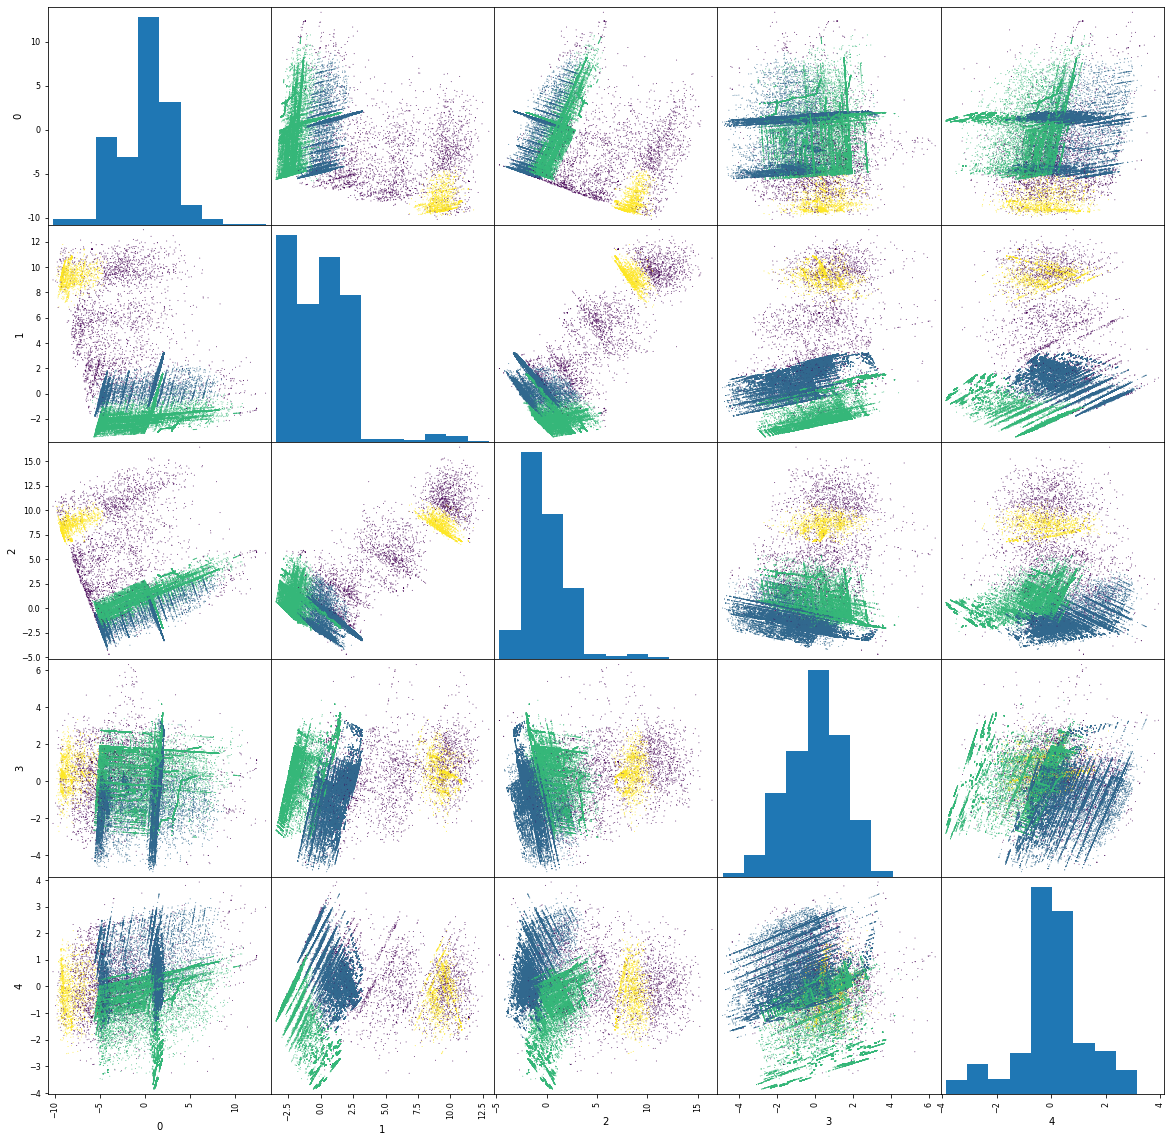

In [18]:
pd.plotting.scatter_matrix(reduced_df, figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 1, alpha = 0.8, c = labels)

In [ ]:
import seaborn as sns

In [ ]:
sns.plot(data=trans_df, x='age_days', hue='labels')

In [ ]:
trans_df['labels'] = labels

In [19]:
from sklearn.manifold import TSNE

In [20]:
df_embedded = TSNE(n_components=2).fit_transform(reduced_df)

In [21]:
df_embedded = pd.DataFrame(df_embedded)

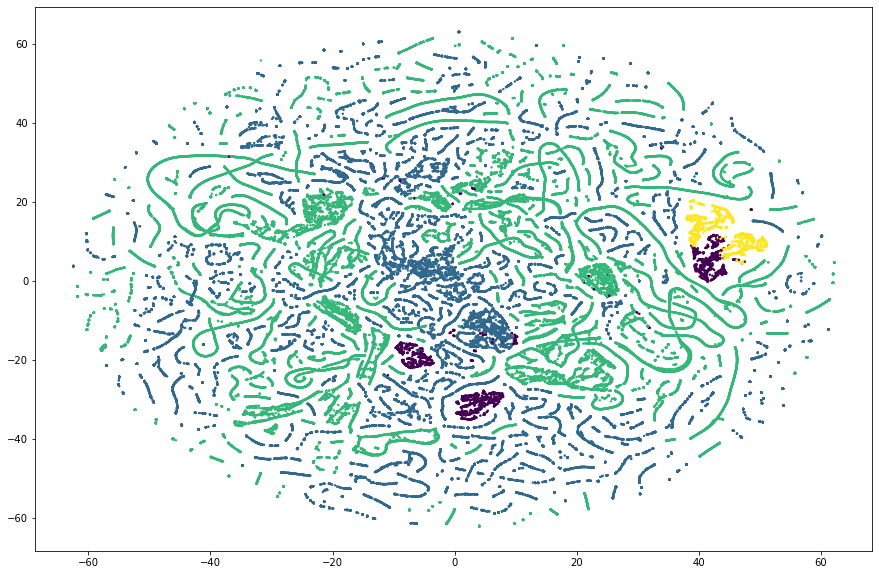

In [23]:
plt.figure(figsize=(15, 10))
plt.scatter(df_embedded[0], df_embedded[1], s=2, c=labels)

In [ ]:
from sklearn.cluster import KMeans

scores = []

for n in range(2,20):
    
    kmeans = KMeans(n_clusters=n, random_state=42).fit(reduced_df)

    km_labels = kmeans.labels_
    scores.append(metrics.calinski_harabasz_score(reduced_df, km_labels))
    
plt.plot(scores)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(reduced_df)

km_labels = kmeans.labels_
metrics.calinski_harabasz_score(reduced_df, km_labels)

In [ ]:
pd.plotting.scatter_matrix(reduced_df, figsize=(20,20), marker = 'o', hist_kwds = {'bins': 10}, s = 1, alpha = 0.8, c = km_labels)

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(df_embedded[0], df_embedded[1], s=2, c=km_labels, cmap='Paired')

In [ ]:
import umap

In [ ]:
df_umap = umap.UMAP(n_neighbors=5, random_state=42).fit_transform(reduced_df)

# Assembling labled cluster

In [ ]:
#################
## 5) ASSEMBLE DF WITH 2 COLUMNS: ADDRESS AND CLUSTER LABEL
#################

wallets = pd.DataFrame()

wallets['address'] = trx11['address']
wallets['label'] = labels

In [ ]:
wallets

## Query sent and received (separately) per wallet per hour

In [ ]:
#################
## 6) QUERY SENT AMOUNTS OF BTC FROM EACH WALLET PER HOUR
#################

sent_q = """
    SELECT 
        TIMESTAMP_TRUNC(t.block_timestamp, HOUR) as date_hour,
        ARRAY_TO_STRING(i.addresses, '') as address,
        sum(i.value) / 100000000 as sum
    FROM `bigquery-public-data.crypto_bitcoin.transactions` as t, 
    UNNEST(inputs) as i
    WHERE t.block_timestamp_month < '2011-01-01'
    GROUP BY 1, 2
"""

print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

In [ ]:
#################
## 7) QUERY RECEIVED AMOUNTS OF BTC TO EACH WALLET PER HOUR
#################

received_q = """
    SELECT 
        TIMESTAMP_TRUNC(t.block_timestamp, HOUR) as date_hour,
        ARRAY_TO_STRING(o.addresses, '') as address,
        sum(o.value) / 100000000 as sum
    FROM `bigquery-public-data.crypto_bitcoin.transactions` as t, 
    UNNEST(outputs)as o
    WHERE t.block_timestamp_month < '2011-01-01'
    GROUP BY 1, 2
"""

print (str(round((bq_assistant.estimate_query_size(q)),2))+str(" GB"))

In [ ]:
query_job = client.query(sent_q)

# API request - run the query, and convert the results to a pandas DataFrame
sent = query_job.to_dataframe()

query_job = client.query(received_q)

# API request - run the query, and convert the results to a pandas DataFrame
received = query_job.to_dataframe()

In [ ]:
sent

In [ ]:
#################
## 6) JOIN SENT AMOUNT BY WALLETS WITH ITS LABELS (AND SAME FOR RECEIVED)
#################

#sent.address = sent.address.astype(str)
#received.address = received.address.astype(str)

labeled_sent = sent.merge(wallets, left_on='address', right_on='address')
labeled_received = received.merge(wallets, left_on='address', right_on='address')

In [ ]:
labeled_sent

In [ ]:
labeled_received

In [ ]:
#################
## 8) PIVOT RESULTING SENT DF, WHERE INDEX(ROWS) - HOURS, COLUMNS - LABEL, VALUES - SUMS
#################

pivot_sent = pd.pivot_table(labeled_sent, values='sum', index=['date_hour'], columns=['label'], aggfunc=np.sum)
pivot_sent.columns = ['cluster1', 'cluster2', 'cluster3', 'cluster4']

pivot_sent = pivot_sent * (-1)

In [ ]:
pivot_sent

In [ ]:
#################
## 9) SAME AS ABOOVE FOR RECEIVED
#################

pivot_received = pd.pivot_table(labeled_received, values='sum', index=['date_hour'], columns=['label'], aggfunc=np.sum)
pivot_received.columns = ['cluster1', 'cluster2', 'cluster3', 'cluster4']

pivot_received

In [ ]:
#################
## 9) JOIN SENT AND RECEIVED PIVOTS ON HOURS
#################

full_flows = pivot_received.merge(pivot_sent, how='outer', left_on='date_hour', right_on='date_hour', suffixes=('_rec', '_sent'))

In [ ]:
full_flows

In [ ]:
#################
## 11) JOIN BTC PRICES TO FLOWS DF
## NEXT - SUPERVISED LEARNING AND TIMESERIES
#################